<a href="https://colab.research.google.com/github/NIKHIL-KHAIRNAR/Calpy/blob/master/Image_Resolution_CNN_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libs
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Add, LeakyReLU,Input, Flatten,Dense,Reshape
from keras.utils import np_utils, plot_model
from keras.optimizers import Adam
from keras.models import Model
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import cv2
import os


# **Loading Dataset**

In [ ]:
# Extracting the zip Folder 
file_name = 'dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Dataset Folder is Extracted SuccessFully!")

Dataset Folder is Extracted SuccessFully!


# Helper Functions

In [9]:
def preprocessing_data(data_set, path, size):
  train_x = []
  for i in data_set:
    image_path = path + i
    img = load_img(image_path, target_size=(size, size))
    x = img_to_array(img)

    # Normalizing data
    x = x.astype('float32')/255. 
    train_x.append(x)
  return train_x

In [10]:
def add_noise_to_data(noise_factor, data):
  noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 
  # limiting the values between 0 to 1 
  noisy_data = np.clip(noisy_data, 0., 1.)
  return noisy_data


In [11]:
def show_images(no_of_images, data_set, label, font_size, path):
  canvas = plt.figure(figsize= (no_of_images,no_of_images))
  for i in range(no_of_images):
    canvas.add_subplot(no_of_images/2, no_of_images/2, i+1) 
    plt.imshow(data_set[i]) 
    plt.axis("off")
  canvas.suptitle(label,fontsize= font_size)
  canvas.savefig(path)
  plt.show()

In [12]:
def plot_graphs(fig_size, data, label, title_of_graph, x_label, y_label, path,is_two_curves):
  canvas = plt.figure(figsize=fig_size)
  canvas.add_subplot()

  if is_two_curves:
    plt.plot(data[0], data[1], label=label[0])
    plt.plot(data[0], data[2], label=label[1])
  else:
    plt.plot(data[0], data[1], label=label)

  plt.title(title_of_graph, fontsize = 18)
  plt.xlabel(x_label, fontsize = 15)
  plt.title(title_of_graph, fontsize = 15)
  plt.legend()
  plt.savefig(path )
  plt.show()




In [ ]:
def encoder(filter, filter_size, size, activation_function, input_to_layer, stride):
  # Layer 1
  x = Conv2D(filter, (filter_size,filter_size),strides= stride, padding='same')(input_to_layer)
  x = LeakyReLU()(x)

  # Layer 2
  x = Conv2D(filter*2, (filter_size,filter_size),strides= stride, padding='same')(x)
  x = LeakyReLU()(x)

  # Layer 3 -- Skip connection to decoder
  skip1 = Conv2D(filter*4, (filter_size,filter_size), strides= stride, padding='same')(x) # skip connection for decoder
  x = LeakyReLU()(skip1)

  # Layer 4
  x = Conv2D(filter*8, (filter_size,filter_size),strides= stride, padding='same')(x)
  x = LeakyReLU()(x)

  # Layer 6  -- Skip connection to decoder
  skip2 = Conv2D(filter*8, (filter_size,filter_size), strides= stride, padding='same')(x) # skip connection for decoder
  x = LeakyReLU()(skip2)

  # Layer 7
  x = Conv2D(filter*16, (filter_size,filter_size),strides= stride, padding='same')(x)
  x = LeakyReLU()(x)

  #Layer 8 - final convolutional layer 
  x = Conv2D(filter*32, (filter_size,filter_size),strides= stride, padding='same')(x)
  x = LeakyReLU()(x)

  f_layer = x.shape

  y = Flatten()(x)

  #This layers neurons are connected to every neuron of Layer 8 --- Most useful Layer
  bottle_neck_layer = Dense(size, activation= activation_function)(y)

  return bottle_neck_layer, f_layer, skip1, skip2

In [ ]:
def decoder(filter, filter_size, input_to_layer, f_layer_shape, activation_function, stride, skip_layer1, skip_layer_2):
 
  #Layer 1
  x = Dense(np.prod(f_layer_shape[1:]), activation=activation_function)(input_to_layer)
  x = Reshape((f_layer_shape[1], f_layer_shape[2], f_layer_shape[3]))(x)

  #Layer 2
  x = Conv2DTranspose(filter*32, (filter_size,filter_size), padding='same')(x)
  x = LeakyReLU()(x)


  #Layer 3
  x = Conv2DTranspose(filter*16, (filter_size,filter_size),strides=stride, padding='same')(x)
  x = LeakyReLU()(x)


  #Layer 4
  x = Conv2DTranspose(filter*8, (filter_size,filter_size),strides=stride, padding='same')(x)
  x = Add()([skip_layer_2,x])
  x = LeakyReLU()(x)
  x = BatchNormalization()(x)
  
  #Layer 5
  x = Conv2DTranspose(filter*8, (filter_size,filter_size),strides=stride, padding='same')(x)
  x = LeakyReLU()(x)


  #Layer 6
  x = Conv2DTranspose(filter*4, (filter_size,filter_size),strides=stride, padding='same')(x)
  x = Add()([skip_layer1,x])
  x = LeakyReLU()(x)
  x = BatchNormalization()(x)  
  
  #Layer 8
  x = Conv2DTranspose(filter*2, (filter_size,filter_size),strides=stride, padding='same')(x)
  x = LeakyReLU()(x)

  #Layer 9
  x = Conv2DTranspose(filter, (filter_size,filter_size),strides=stride, padding='same')(x)
  x = LeakyReLU()(x)
  
  x = Conv2DTranspose(filter_size, (filter_size, filter_size), activation='sigmoid', strides=stride ,padding='same')(x)
  return x

In [ ]:

def create_cnn_auto_encoder(filter, filter_size, size, activation_function, input_to_layer, stride):
  #encoder
  bottle_neck_layer, f_layer_shape, skip_layer1, skip_layer_2 = encoder(filter, filter_size, size, activation_function, input_to_layer, stride)

  #decoder
  decoded = decoder(filter, filter_size, bottle_neck_layer, f_layer_shape, activation_function, stride, skip_layer1, skip_layer_2)

  return decoded

## **Setting Variables and creating a model to train**

---



In [ ]:
# setting some variables
size = 128        # sets the image size
channel = 3       # Because of colored images / Rgb Images 
training_data_path = 'dataset/training_dataset/BSDS200/'
testing_data_path = 'dataset/testing_dataset/BSDS100/'

In [ ]:
training_image_set = sorted(os.listdir(training_data_path))
testing_image_set = sorted(os.listdir(testing_data_path))

In [ ]:
x_train = np.array(preprocessing_data(training_image_set,training_data_path,size))
x_train.shape

(200, 128, 128, 3)

In [ ]:
x_test = np.array(preprocessing_data(testing_image_set,testing_data_path,size))
x_test.shape

(100, 128, 128, 3)

**Adding Noise to the Input Image**

> Noise Factor will add that much percentage of Noise to the image for which it is set.




In [ ]:
noise_factor = 0.3  # adding 30% noise to the images

x_train_noisy = add_noise_to_data(noise_factor, x_train)

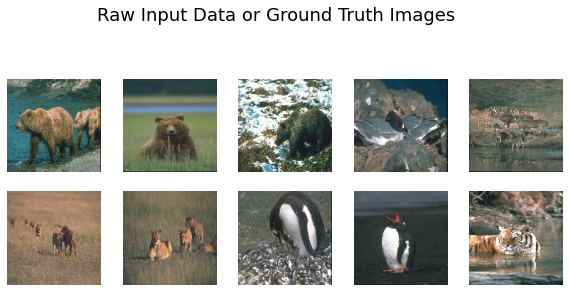

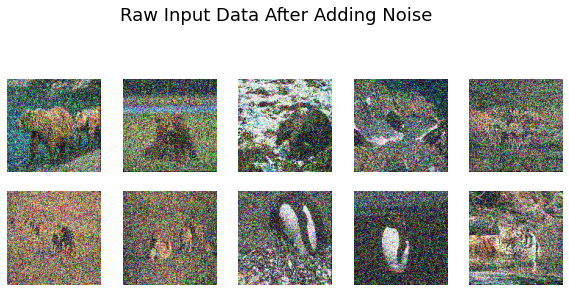

In [ ]:
# showing Input Raw Data
show_images(10, x_train, "Raw Input Data or Ground Truth Images", 18)

# Showing Input After Adding Noise
show_images(10, x_train_noisy, "Raw Input Data After Adding Noise", 18)


In [ ]:

inputs = Input(shape=(size,size,channel))

# setting paramters for the model
filter = 32
filter_size = 3
activation_function = 'relu'
stride = (2,2)

outputs = create_cnn_auto_encoder(filter, filter_size,size, activation_function, inputs, stride)


# 
model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 32)   896         ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 64, 64, 32)   0           ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 64)   18496       ['leaky_re_lu_14[0][0]']   

In [ ]:
learning_rate = 0.001
beta_1 = 0.9  # hyper parameter to overcome the saddel point or local minima [For more details please read the paper]
loss_function = 'binary_crossentropy'

model.compile(optimizer=Adam(learning_rate, beta_1= beta_1), loss=loss_function,metrics=['accuracy'])

In [ ]:
# Training
epochs = 200
batch_size = 32

model_training_history = model.fit(x_train_noisy,
                x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.1
               )

Epoch 1/200
6/6 [==============================] - 33s 4s/step - loss: 0.5780 - accuracy: 0.6295 - val_loss: 0.7773 - val_accuracy: 0.4422
Epoch 2/200
6/6 [==============================] - 21s 4s/step - loss: 0.5764 - accuracy: 0.6368 - val_loss: 0.8669 - val_accuracy: 0.5106
Epoch 3/200
6/6 [==============================] - 21s 4s/step - loss: 0.5763 - accuracy: 0.6523 - val_loss: 0.8110 - val_accuracy: 0.5451
Epoch 4/200
6/6 [==============================] - 21s 4s/step - loss: 0.5750 - accuracy: 0.6447 - val_loss: 0.8697 - val_accuracy: 0.5247
Epoch 5/200
6/6 [==============================] - 21s 4s/step - loss: 0.5756 - accuracy: 0.6481 - val_loss: 0.7866 - val_accuracy: 0.5619
Epoch 6/200
6/6 [==============================] - 21s 4s/step - loss: 0.5725 - accuracy: 0.6650 - val_loss: 0.7358 - val_accuracy: 0.5681
Epoch 7/200
6/6 [==============================] - 21s 4s/step - loss: 0.5727 - accuracy: 0.6454 - val_loss: 0.7080 - val_accuracy: 0.5454
Epoch 8/200
6/6 [==========

In [ ]:
model_name = "restoration_image.h5"
model.save("dataset/saved_model/"+model_name)

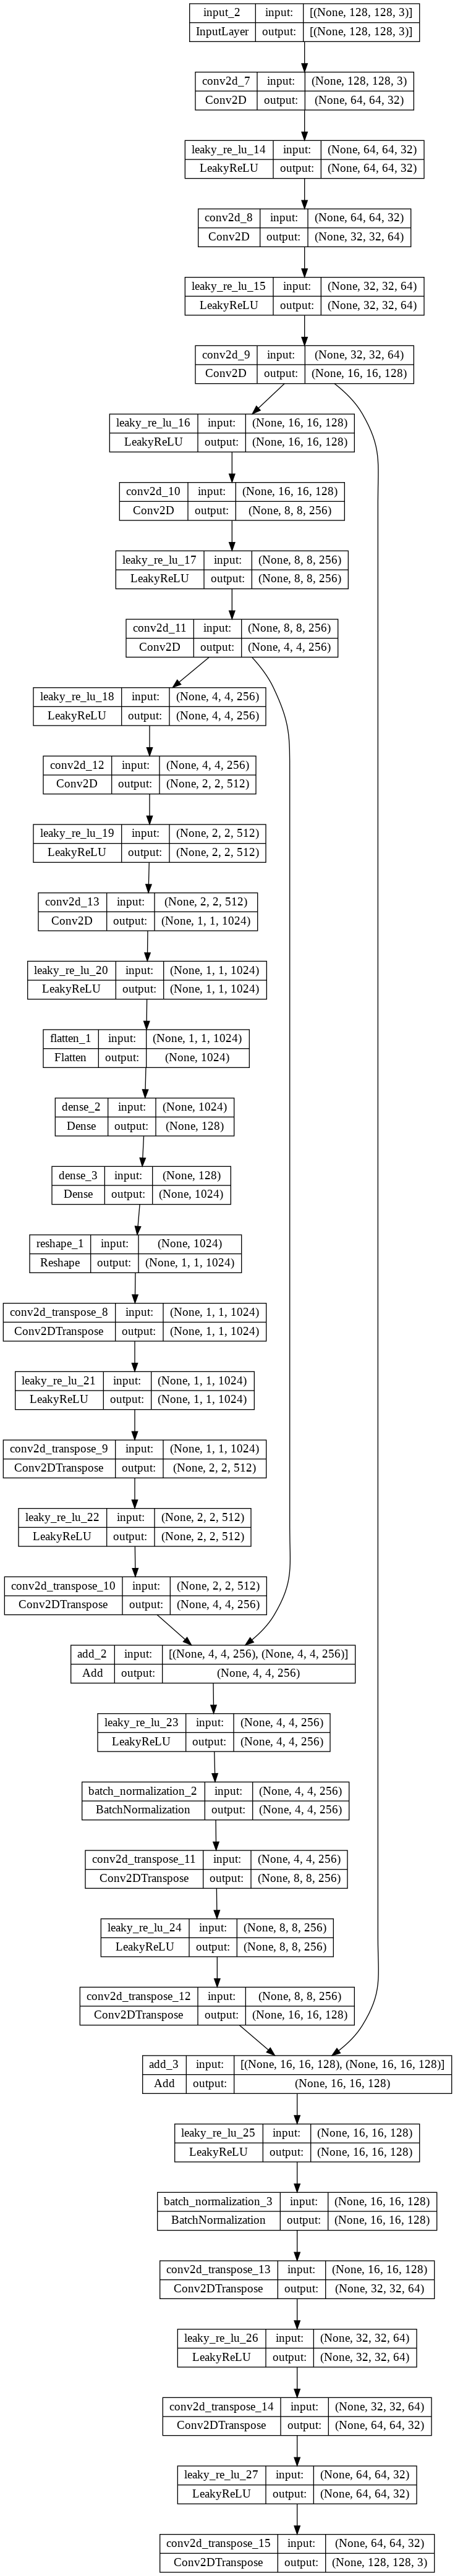

In [ ]:
plot_model(model, to_file='dataset/results/model.png', show_shapes=True, show_layer_names=True)

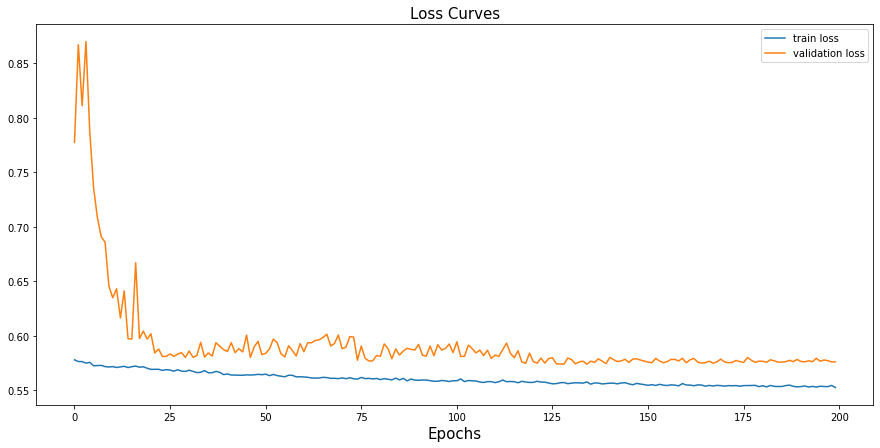

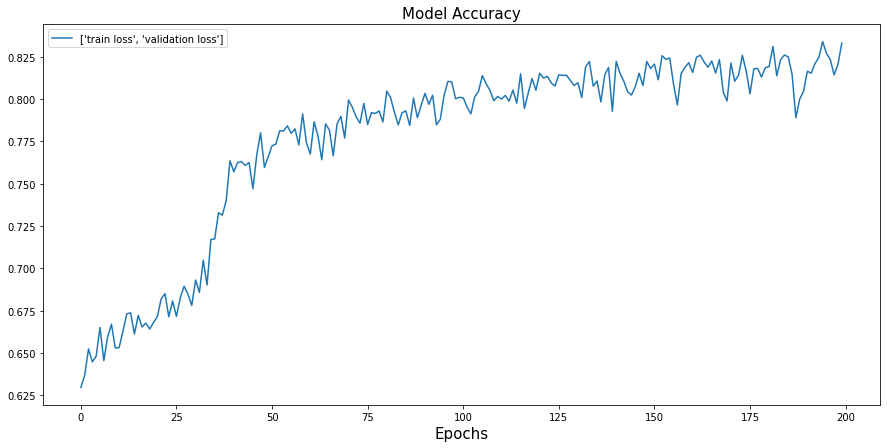

In [ ]:
data = [model_training_history.epoch, model_training_history.history['loss'],
        model_training_history.history['val_loss']]

label = ["train loss", "validation loss"]

# plotting Loss Curves with respect to Epochs
plot_graphs((15,7),data, label, title_of_graph ="Loss Curves", x_label = "Epochs", y_label = "Loss", path = "dataset/results/Loss_curves.png",is_two_curves=True)

#plotting Accuracy of Model with respect to Epochs
plot_graphs((15,7),[model_training_history.epoch, model_training_history.history['accuracy'] ], 
            label, title_of_graph ="Model Accuracy", x_label = "Epochs", y_label = "Accuracy", path = "dataset/results/Model_Accuracy.png",is_two_curves=False)


**Testing the Model on Test Data**

In [ ]:
noise_factor = 0.2  # adding 30% noise to the images
x_test_noisy = add_noise_to_data(noise_factor, x_test)

In [ ]:
# Select few random test images
num_of_images = 10
rand = np.random.randint(1, x_test_noisy.shape[0]- num_of_images) 

testing_images = x_test_noisy[rand:rand+num_of_images]


In [ ]:
# Reconstructing
model_output = model.predict(testing_images)

1/1 [==============================] - 1s 583ms/step


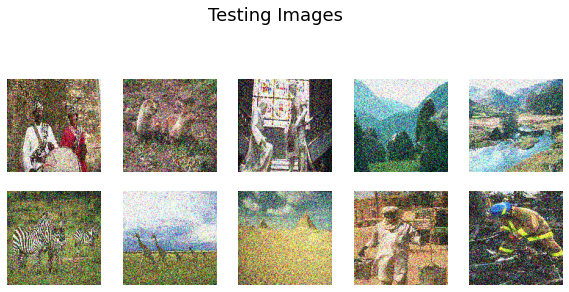

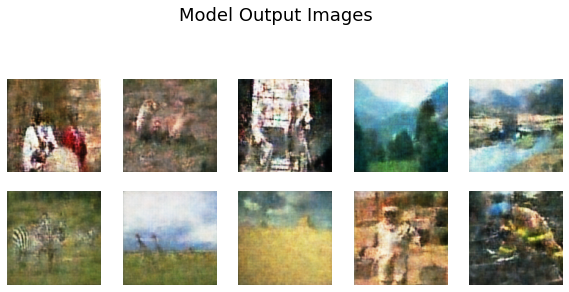

In [ ]:
# showing test images
show_images(10, testing_images, "Testing Images", 18, 'dataset/results/testing_images.png')

# Showing model output images
show_images(10, model_output, "Model Output Images", 18, 'dataset/results/model_output_images.png')

**Inference**

*   The Model's Accuracy is Good when compared to normal CNN Auto Encoder without  Skip connections but since because of use of deconvolution Layer where the filter of size in our case 3X3 maps one pixel from input to output and hence we see the checkerboard artifacts.


* Solution for chekerboard artifacts please read the paper submitted with this code





#**Test the model** -- playground



In [2]:
from tensorflow.keras.models import load_model

In [34]:
# Extracting the zip Folder 
file_name = 'dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Data Folder is Extracted SuccessFully!")

Data Folder is Extracted SuccessFully!


In [35]:
# setting some variables
size = 128        # sets the image size
channel = 3       # Because of colored images / Rgb Images 
testing_data_path = 'dataset/testing_dataset/BSDS100/'

In [36]:
testing_image_set = sorted(os.listdir(testing_data_path))

In [37]:
x_test = np.array(preprocessing_data(testing_image_set,testing_data_path,size))
x_test.shape

(100, 128, 128, 3)

In [38]:
# Adding noise to test data
noise_factor = 0.3  # adding 30% noise to the images
x_test_noisy = add_noise_to_data(noise_factor, x_test)

In [39]:
# Select few random test images
num_of_images = 10
rand = np.random.randint(1, x_test_noisy.shape[0]- num_of_images) 

testing_images = x_test_noisy[rand:rand+num_of_images]

In [40]:
# Load the model
prev_model = load_model('restoration_image.h5')

In [41]:
# Reconstructing
model_output_1 = prev_model.predict(x_test_noisy)

4/4 [==============================] - 6s 1s/step


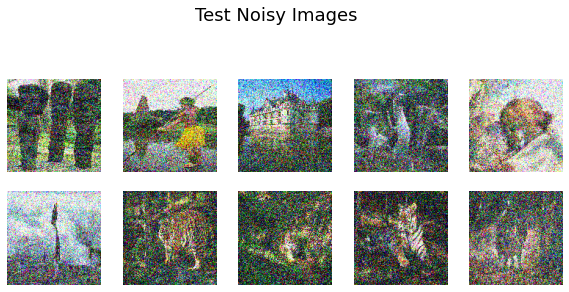

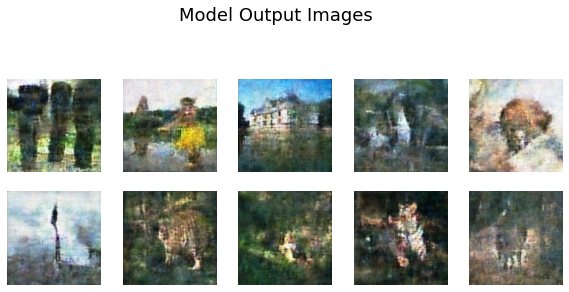

In [42]:
# showing test images
show_images(num_of_images, x_test_noisy, "Test Noisy Images", 18, 'dataset/test_noisy_images.png')

# Showing model output images
show_images(num_of_images, model_output_1, "Model Output Images", 18, 'dataset/model_output_images.png')